In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# Importing libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [56]:
base_dir ='/content/drive/MyDrive/Model_O/Dataset'

In [57]:
# Function to identify and remove unsupported images
def filter_images(directory):
  """
  Identifies and removes images with unsupported formats from the directory.

  Args:
    directory: The directory containing the images.

  Returns:
    None
  """
  for root, _, files in os.walk(directory):
    for file in files:
      file_path = os.path.join(root, file)
      try:
        # Check if the file is an image and has a supported format
        if imghdr.what(file_path) not in ['jpeg', 'png', 'gif', 'bmp']:
          print(f"Removing unsupported file: {file_path}")
          os.remove(file_path)
      except Exception as e:
        print(f"Error processing file {file_path}: {e}")

In [58]:
# Filter out unsupported image files from the dataset directory
filter_images(base_dir)

Error processing file /content/drive/MyDrive/Model_O/Dataset/normal/105.jpg: name 'imghdr' is not defined
Error processing file /content/drive/MyDrive/Model_O/Dataset/normal/102.jpg: name 'imghdr' is not defined
Error processing file /content/drive/MyDrive/Model_O/Dataset/normal/104.jpg: name 'imghdr' is not defined
Error processing file /content/drive/MyDrive/Model_O/Dataset/normal/1.jpg: name 'imghdr' is not defined
Error processing file /content/drive/MyDrive/Model_O/Dataset/normal/103.jpg: name 'imghdr' is not defined
Error processing file /content/drive/MyDrive/Model_O/Dataset/normal/100.jpg: name 'imghdr' is not defined
Error processing file /content/drive/MyDrive/Model_O/Dataset/normal/10.jpg: name 'imghdr' is not defined
Error processing file /content/drive/MyDrive/Model_O/Dataset/normal/101.jpg: name 'imghdr' is not defined
Error processing file /content/drive/MyDrive/Model_O/Dataset/normal/122.jpg: name 'imghdr' is not defined
Error processing file /content/drive/MyDrive/Mode

In [59]:
# Fetch images count from folders

count = 0
dirs = os.listdir('/content/drive/MyDrive/Model_O/Dataset')
for dir in dirs:
  files = list(os.listdir('/content/drive/MyDrive/Model_O/Dataset/' + dir))
  print(dir + ' folder has ' + str(len(files)) + ' Images')
  count = count + len(files)
  print('Dataset folder has ', count)

normal folder has 338 Images
Dataset folder has  338
potholes folder has 314 Images
Dataset folder has  652


In [60]:
img_size = 180
batch = 32

In [61]:
# Load images into arrays as Dataset

train_ds = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                       seed=123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,
                                                                   img_size))

validation_ds = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                       seed=123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,
                                                                   img_size))

Found 652 files belonging to 2 classes.
Using 522 files for training.
Found 652 files belonging to 2 classes.
Using 130 files for validation.


In [62]:
class_name = train_ds.class_names
class_name

['normal', 'potholes']

In [63]:
import matplotlib.pyplot as plt

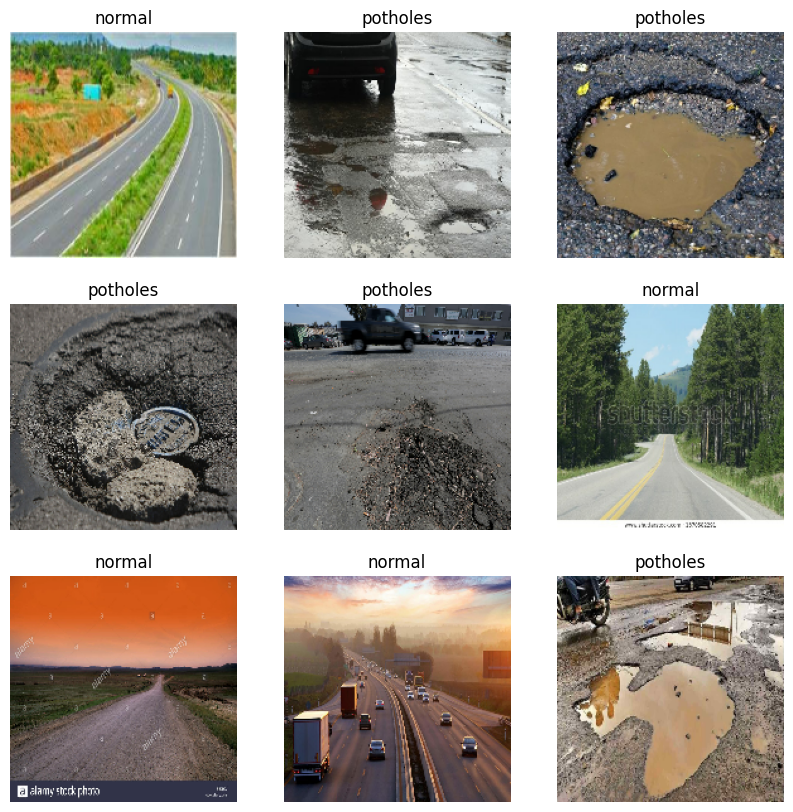

In [64]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis('off')

In [65]:
AUTOTUNE = tf.data.AUTOTUNE

In [66]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [67]:
# Data preprocessing

data_augmentation = Sequential([
    layers.RandomFlip('horizontal', input_shape = (img_size, img_size ,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

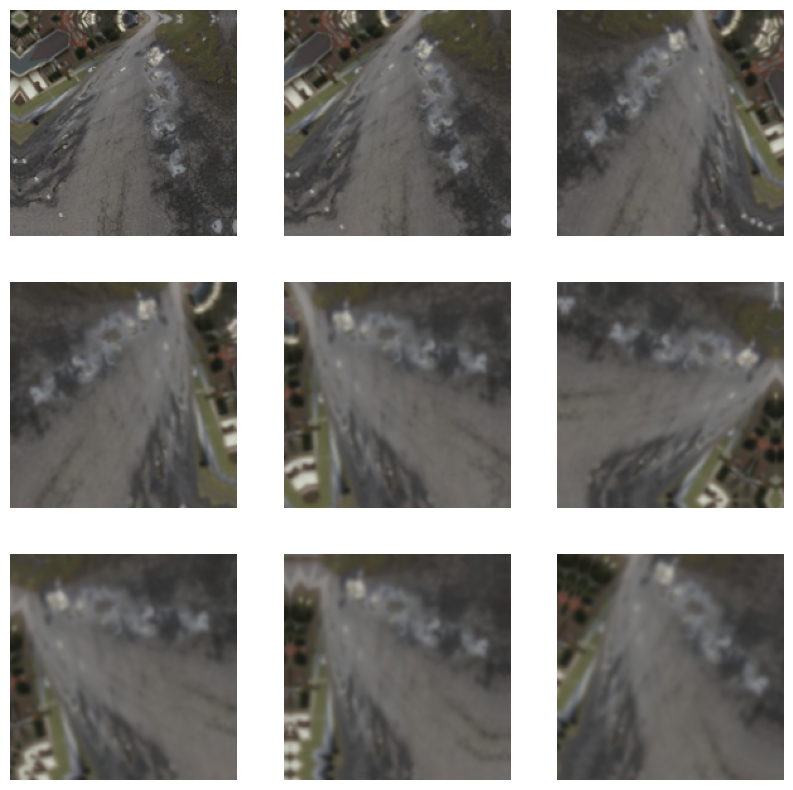

In [68]:
# Preprocessing

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    images = data_augmentation(images)
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.axis('off')

In [69]:
# Model Creation

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [70]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [71]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
history = model.fit(train_ds, epochs=15, validation_data=validation_ds)

Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4709 - loss: 2.5860 - val_accuracy: 0.4846 - val_loss: 0.6763
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5996 - loss: 0.6381 - val_accuracy: 0.6462 - val_loss: 0.5421
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8054 - loss: 0.4136 - val_accuracy: 0.8769 - val_loss: 0.3040
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8244 - loss: 0.3930 - val_accuracy: 0.8308 - val_loss: 0.3463
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8242 - loss: 0.3805 - val_accuracy: 0.9154 - val_loss: 0.2241
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8923 - loss: 0.2860 - val_accuracy: 0.8692 - val_loss: 0.3262
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8343 - loss: 0.3684 - val_accuracy: 0.8308 - val_loss: 0.3391
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8641 - loss: 0.3258 - val_accuracy: 0.8923 - val_loss:

In [73]:
input_image = tf.keras.utils.load_img('/content/Unknown.jpeg', target_size=(img_size, img_size))
input_image_array = tf.keras.utils.img_to_array(input_image)
input_image_exp_dim = tf.expand_dims(input_image_array, 0)

predictions = model.predict(input_image_exp_dim)
result = tf.nn.softmax(predictions[0])
class_name[np.argmax(result)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


'potholes'